In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import learning_curve, cross_val_score, KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

In [ ]:
# Optional: Load and inspect severity data if needed for feature names or weights
# severity = pd.read_csv('../../data/raw/Symptom-severity.csv')
# print("Severity Mapping:\n", severity.head())
# print("\nTotal unique symptoms in severity data:", severity['Symptom'].nunique())

In [18]:
# Load raw training data
df_train = pd.read_csv('../../data/raw/dataset.csv')

# --- Feature Engineering ---
# Identify symptom columns (assuming they are named like 'Symptom_1', 'Symptom_2', etc.)
symptom_cols = [col for col in df_train.columns if 'Symptom_' in col]

# Drop the 'Unnamed: 133' column if it exists
if 'Unnamed: 133' in df_train.columns:
    df_train = df_train.drop('Unnamed: 133', axis=1)

# Get the target variable first
y = df_train['Disease']

# Create a list to hold all unique symptoms
all_symptoms_list = []
for col in symptom_cols:
    # Clean symptom names (remove leading/trailing spaces) and drop NaNs
    cleaned_symptoms = df_train[col].str.strip().dropna().unique()
    all_symptoms_list.extend(cleaned_symptoms)

# Get unique symptoms
unique_symptoms = sorted(list(set(all_symptoms_list)))
print(f"Found {len(unique_symptoms)} unique symptoms.")

# Create the new feature matrix initialized with zeros
X_processed = pd.DataFrame(0, index=df_train.index, columns=unique_symptoms)

# Populate the matrix: 1 if the symptom is present for the row, 0 otherwise
for index, row in df_train.iterrows():
    present_symptoms = [s.strip() for s in row[symptom_cols].dropna().tolist() if isinstance(s, str) and s.strip()]
    for symptom in present_symptoms:
        if symptom in X_processed.columns:
            X_processed.loc[index, symptom] = 1

# --- Target Encoding ---
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
target_names = le_target.classes_.tolist()
feature_names = X_processed.columns.tolist()  

# --- Data Splitting ---
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

Found 131 unique symptoms.


In [ ]:
# Display feature names and target names mapping (optional check)
# print("Feature Names:", feature_names)
# print("Target Names:", target_names)
# print("Target Encoding Map:", dict(zip(le_target.classes_, le_target.transform(le_target.classes_))))

In [9]:
# Create multiple models
models = {
    'rf': RandomForestClassifier(random_state=42),
    'xgb': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),  
    'lr': LogisticRegression(random_state=42, max_iter=1000) 
}

In [10]:
# Define parameter grids for each model - Adjusted for Regularization & NB
param_grids = {
    'rf': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 3, 5],
        'class_weight': ['balanced']
    },
    'xgb': {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 7, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [0.5, 1],
        'gamma': [0, 0.1]
    },
    'lr': {  
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],  # 'elasticnet' can be added if using 'saga' solver
        'solver': ['liblinear', 'saga']  # 'saga' is good for larger datasets
    }
}

In [13]:
# Train and evaluate each model
best_models = {}
model_scores = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Use RandomizedSearchCV for efficiency
    search = RandomizedSearchCV(
        model,
        param_distributions=param_grids[name],
        cv=5,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1,
        n_iter=10,  # Adjust n_iter based on computational resources
        random_state=42
    )
    
    # Use the processed feature matrix X_train
    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_
    
    # Evaluate on the processed test set X_test
    y_pred = best_models[name].predict(X_test)
    score = classification_report(y_test, y_pred, target_names=target_names, zero_division=0)
    model_scores[name] = score
    
    print(f"\n{name} Best Parameters:", search.best_params_)
    print(f"\n{name} Performance:\n", score)


Training rf...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

rf Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20, 'class_weight': 'balanced'}

rf Performance:
                                          precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        24
                                   AIDS       1.00      1.00      1.00        24
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        24
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        24
                       Bronchial Asthma       1.00      1.00      1.00        24
                   Cervical spondylosis       1.00      1.00      1.00        24
                            Chicken pox 

d:\Download\Anaconda\anaconda3\envs\conda_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:11:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



xgb Best Parameters: {'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0}

xgb Performance:
                                          precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        24
                                   AIDS       1.00      1.00      1.00        24
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        24
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        24
                       Bronchial Asthma       1.00      1.00      1.00        24
                   Cervical spondylosis       1.00      1.00      1.00        24
                            Chicken pox       1.00      1.00      1.00        24
                    Chronic cholestasis  

In [14]:
#create voting classifier with equal weights
voting_clf = VotingClassifier(
    estimators=[(name, model) for name, model in best_models.items()],
    voting='soft', # Soft voting requires predict_proba
    weights=[1, 1, 1] # Equal weights for RF, XGB, NB
)

# Fit on processed training data
voting_clf.fit(X_train, y_train)
# Predict on processed test data
y_pred_voting = voting_clf.predict(X_test)
voting_score = classification_report(y_test, y_pred_voting, target_names=target_names, zero_division=0)
print("\nVoting Classifier Performance:\n", voting_score)

d:\Download\Anaconda\anaconda3\envs\conda_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:17:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Voting Classifier Performance:
                                          precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        24
                                   AIDS       1.00      1.00      1.00        24
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        24
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        24
                       Bronchial Asthma       1.00      1.00      1.00        24
                   Cervical spondylosis       1.00      1.00      1.00        24
                            Chicken pox       1.00      1.00      1.00        24
                    Chronic cholestasis       1.00      1.00      1.00        24
                            Common Cold       1.00      1.00      1.00     

In [15]:
# Learning Curve
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, valid_scores = learning_curve(
    voting_clf,
    X_train, 
    y_train,
    train_sizes=train_sizes,
    cv=5, 
    scoring='f1_weighted',
    n_jobs=-1
)

In [16]:
# Compute mean and standard deviation of training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

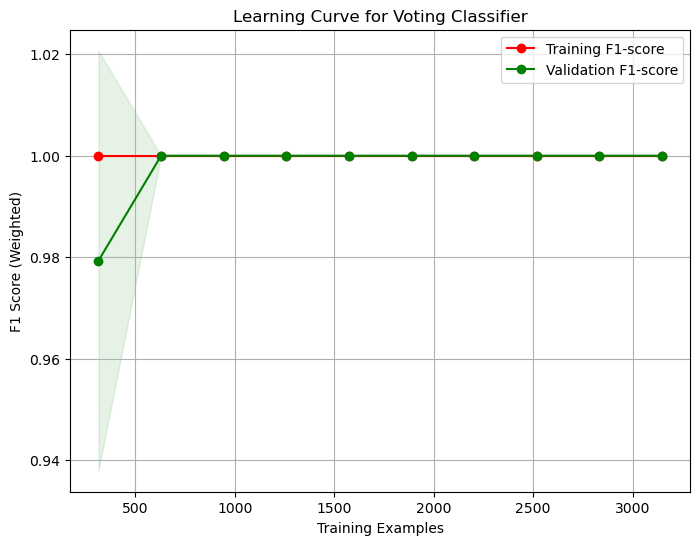

In [17]:
# Plot learning curve
plt.figure(figsize=(8, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training F1-score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Validation F1-score")

plt.xlabel("Training Examples")
plt.ylabel("F1 Score (Weighted)")
plt.title("Learning Curve for Voting Classifier")
plt.legend(loc="best")
plt.grid()
plt.show()

In [19]:
#save Results
results = {
    'models': best_models,
    'voting_classifier': voting_clf,
    'feature_names': feature_names,
    'target_names': target_names,   
    'target_encoder': le_target,  
    'model_scores': model_scores
}

# Save to a new file for v3
joblib.dump(results, '../../models/ensemble_models_v3.joblib')

['../../models/ensemble_models_v3.joblib']

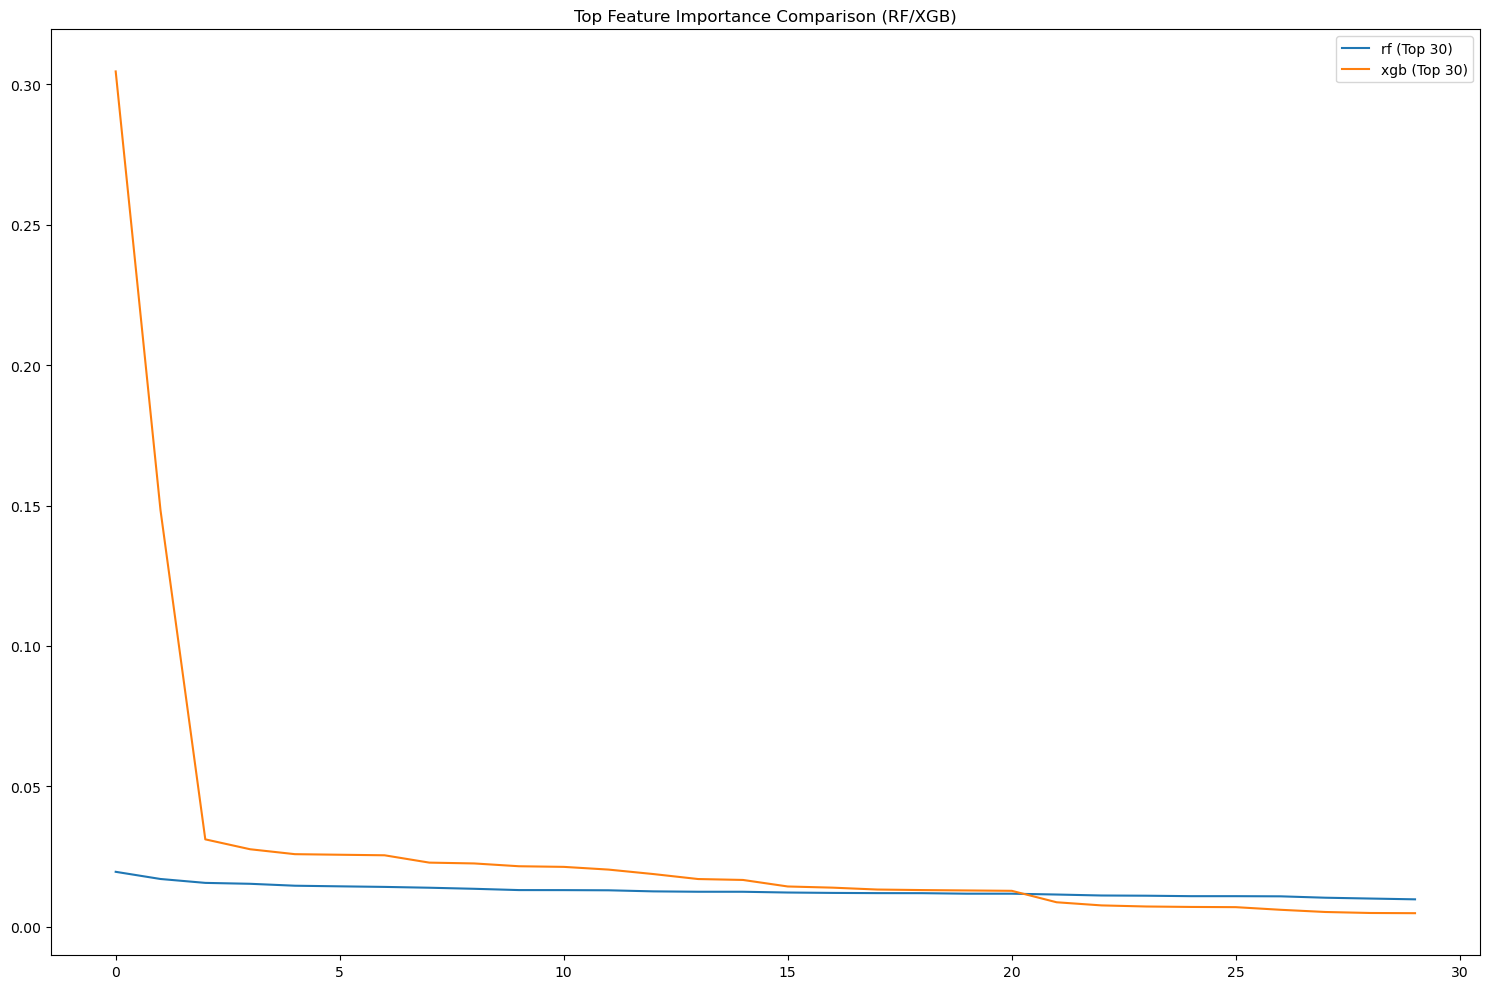

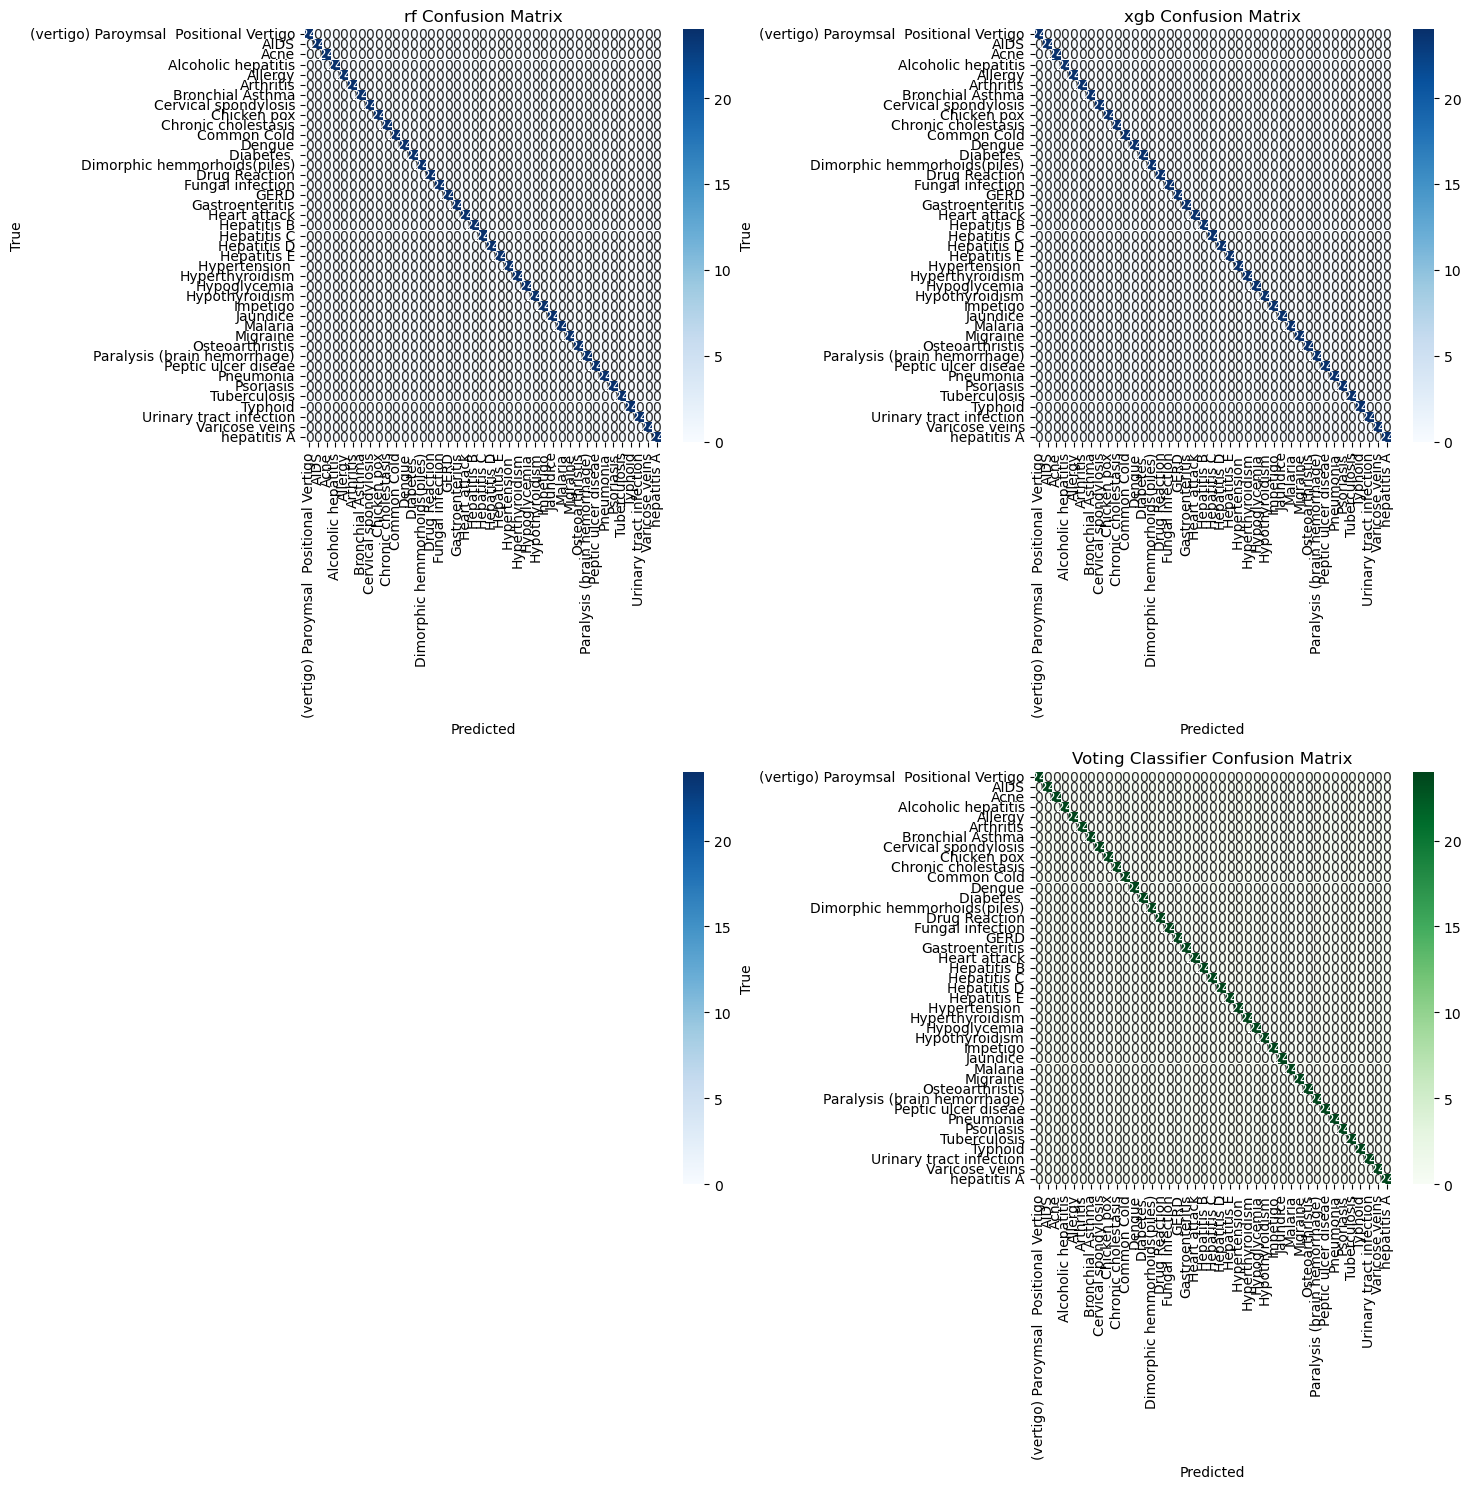

In [20]:
# generate Visualizations (Adjusted for 3 models and new feature names)
def create_visualizations_v3():
    # Feature importance comparison (Only for models that support it)
    plt.figure(figsize=(15, 10))
    feature_importances_available = False
    for name, model in best_models.items():
        if hasattr(model, 'feature_importances_'):
            # Get feature importances and sort them
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]
            # Select top N features for clarity, e.g., top 30
            top_n = 30
            plt.plot(importances[indices][:top_n], label=f'{name} (Top {top_n})')
            feature_importances_available = True
        elif name == 'xgb' and hasattr(model, 'get_booster'): # XGBoost specific way
             try:
                 fscores = model.get_booster().get_score(importance_type='gain') # Use 'gain' or 'weight'
                 # Map feature names (f0, f1...) back to actual symptom names
                 fscores_named = {feature_names[int(k[1:])]: v for k, v in fscores.items()}
                 sorted_fscores = sorted(fscores_named.items(), key=lambda item: item[1], reverse=True)
                 top_n = 30
                 top_features = [item[0] for item in sorted_fscores[:top_n]]
                 top_scores = [item[1] for item in sorted_fscores[:top_n]]
                 plt.plot(top_scores, label=f'{name} (Top {top_n})')
                 feature_importances_available = True 
             except Exception as e:
                 print(f"Could not get/process XGBoost feature importance: {e}")

    if feature_importances_available:

        plt.legend()
        plt.title('Top Feature Importance Comparison (RF/XGB)')
        plt.tight_layout()
        plt.savefig('../../src/visualizations/feature_importance_comparison_v3.png')
        plt.show()
    else:
        plt.close() 
        print("No standard feature importances available for plotting.")

    # Confusion matrices (Adjusted for 3 models in a 2x2 grid)
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    axes_flat = axes.ravel()
    
    # Plot individual models
    for i, (name, model) in enumerate(best_models.items()):
        cm = confusion_matrix(y_test, model.predict(X_test))
        sns.heatmap(cm, annot=True, fmt='d', ax=axes_flat[i], cmap='Blues', 
                    xticklabels=target_names, yticklabels=target_names)
        axes_flat[i].set_title(f'{name} Confusion Matrix')
        axes_flat[i].set_xlabel('Predicted')
        axes_flat[i].set_ylabel('True')

    # Plot voting classifier confusion matrix in the last subplot
    cm_voting = confusion_matrix(y_test, y_pred_voting)
    sns.heatmap(cm_voting, annot=True, fmt='d', ax=axes_flat[3], cmap='Greens',
                xticklabels=target_names, yticklabels=target_names)
    axes_flat[3].set_title('Voting Classifier Confusion Matrix')
    axes_flat[3].set_xlabel('Predicted')
    axes_flat[3].set_ylabel('True')

    # Hide the unused subplot if necessary (e.g., if only 3 models + voting)
    if len(best_models) == 3:
         fig.delaxes(axes_flat[2]) 

    plt.tight_layout()
    plt.savefig('../../src/visualizations/confusion_matrices_v3.png')
    plt.show()

create_visualizations_v3()
